# Atmospheric composition distribution by CAMS and TROPOMI

### Main goal:
* Compare TROPOMI and CAMS datasets for NO<sub>2</sub>, CO, O<sub>3</sub> and SO<sub>2</sub> (Level 2).

## Imports and supporting functions

In [1]:
import os 
from sentinelsat.sentinel import SentinelAPI, geojson_to_wkt
import cdsapi
import cfgrib
import xarray as xr
import pandas as pd
import numpy as np
from itertools import product
import scipy.interpolate
from copy import copy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import math
import geojson
from sklearn.linear_model import LinearRegression
from scipy.spatial.distance import cdist
import datetime as dt
import geocoder
import seaborn as sns
from matplotlib.cbook import boxplot_stats  
from matplotlib import animation
from IPython.display import HTML, display
import urllib3

In [2]:
%run functions/functions_general.ipynb
%run functions/functions_cams.ipynb
%run functions/functions_tropomi.ipynb

In [3]:
# Hide pandas warning
pd.options.mode.chained_assignment = None

# Hide API request warning
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

# Increase animation limit
matplotlib.rcParams['animation.embed_limit'] = 25000000

## 1. Define datasets

In [4]:
# Define component
component_nom = 'NO2'

# Define model
model = 'cams'
model_full_name = 'cams-global-atmospheric-composition-forecasts'

# Define sensor
sensor = 'tropomi'
sensor_type = 'L2'
apply_kernels = True

# Define search period
start_date = '2021-10-28'
end_date = '2021-10-28'

# Define extent
lon_min = 12
lon_max = 18.9
lat_min = 48.5
lat_max = 51.1

# Create bbox
bbox = ((lon_min, lat_min), (lon_max, lat_max))

In [5]:
# Check if comparison is possible
comparison_check(sensor, model, component_nom, model_full_name, sensor_type)

# Get component full name and molecular weight
component, component_mol_weight, product_type, sensor_column = components_table(sensor, component_nom, sensor_type)

# Folders generation
generate_folders(model, sensor, component_nom, sensor_type)

# Generate array with search dates
dates = search_period(start_date, end_date, sensor, sensor_type)

The comparison is possible and will start now.
SEARCH PERIOD
- In days: [('2021-10-28T00:00:00Z', '2021-10-28T23:00:00Z')]


## 2. Model data

### Download and read data as xarray

In [6]:
model_product_name, model_type = CAMS_download(dates, start_date, end_date, component, 
                                               component_nom, model_full_name, model_level = 'Multiple')

The file exists, it will not be downloaded again.


In [7]:
model_ds, _ = CAMS_read(model_product_name, component, component_nom, dates)
model_ds

<xarray.Dataset>
Dimensions:     (hybrid: 137, latitude: 451, longitude: 900, step: 8, time: 1)
Coordinates:
  * time        (time) datetime64[ns] 2021-10-28
  * step        (step) timedelta64[ns] 00:00:00 03:00:00 ... 18:00:00 21:00:00
  * hybrid      (hybrid) float64 1.0 2.0 3.0 4.0 5.0 ... 134.0 135.0 136.0 137.0
  * latitude    (latitude) float64 -90.0 -89.6 -89.2 -88.8 ... 89.2 89.6 90.0
  * longitude   (longitude) float64 -180.0 -179.6 -179.2 ... 178.8 179.2 179.6
    valid_time  (step) datetime64[ns] ...
Data variables:
    component   (time, step, hybrid, latitude, longitude) float32 3.222e-09 ....
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-11-16T23:15 GRIB to CDM+CF via cfgrib-0.9.9...

### Collect 137 levels model data

In [8]:
model_levels_df = CAMS_137_levels()
model_levels_df

,a [Pa],b,ph [hPa],pf [hPa],Geopotential Altitude [m],Geometric Altitude [m],Temperature [K],Density [kg/m^3],ph [Pa],ph-diff [Pa],Depth [m]
hybrid,,,,,,,,,,,
1,2.000365,0.000000,0.0200,0.0100,79301.79,80301.65,198.05,0.000018,2.00,2.00,5580.21
2,3.102241,0.000000,0.0310,0.0255,73721.58,74584.91,209.21,0.000042,3.10,1.10,2605.83
3,4.666084,0.000000,0.0467,0.0388,71115.75,71918.79,214.42,0.000063,4.67,1.57,2497.32
4,6.827977,0.000000,0.0683,0.0575,68618.43,69365.77,221.32,0.000090,6.83,2.16,2407.44
5,9.746966,0.000000,0.0975,0.0829,66210.99,66906.53,228.06,0.000127,9.75,2.92,2320.96
...,...,...,...,...,...,...,...,...,...,...,...
133,62.781250,0.988500,1002.2250,1000.5165,106.54,106.54,287.46,1.212498,100222.50,341.69,27.50
134,22.835938,0.991984,1005.3562,1003.7906,79.04,79.04,287.64,1.215710,100535.62,313.12,25.12
135,3.757813,0.995003,1008.2239,1006.7900,53.92,53.92,287.80,1.218650,100822.39,286.77,22.96


### Convert CAMS data units (kg/kg to molecules/cm<sup>2</sup>)

In [9]:
model_ds, units = model_convert_units(model, model_ds, sensor, 
                                      component_mol_weight, component, model_levels_df,
                                      start_date, end_date, component_nom, apply_kernels)

The columns above each CAMS half level will be calculated.
The model component units have been converted from kg kg**-1 to kg m**-2.
The model component units have been converted from kg m**-2 to molec cm-2.


### Download read and subset original total columns data

In [10]:
model_product_name, model_type = CAMS_download(dates, start_date, end_date, component, component_nom, 
                                               model_full_name, model_level = 'Single')
model_total_ds, _ = CAMS_read(model_product_name, component, component_nom, dates)
model_total_ds = subset(model_total_ds, bbox)
model_total_ds

The file exists, it will not be downloaded again.


<xarray.Dataset>
Dimensions:     (latitude: 8, longitude: 18, step: 8, time: 1)
Coordinates:
    number      int64 ...
  * time        (time) datetime64[ns] 2021-10-28
  * step        (step) timedelta64[ns] 00:00:00 03:00:00 ... 18:00:00 21:00:00
    surface     float64 ...
  * latitude    (latitude) float64 48.4 48.8 49.2 49.6 50.0 50.4 50.8 51.2
  * longitude   (longitude) float64 12.0 12.4 12.8 13.2 ... 17.6 18.0 18.4 18.8
    valid_time  (step) datetime64[ns] ...
Data variables:
    component   (time, step, latitude, longitude) float32 6.826e-06 ... 1.07e-05
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-11-16T23:15 GRIB to CDM+CF via cfgrib-0.9.9...

### Convert CAMS total columns data units (kg/m2 to molecules/cm<sup>2</sup>)

In [11]:
model_total_ds, _ = model_convert_units(model, model_total_ds, sensor,
                                        component_mol_weight, component, model_levels_df,
                                        start_date, end_date, component_nom, apply_kernels)

The model component units have been converted from kg m**-2 to molec cm-2.


## 3. Sensor data

### Download and read data as xarray

In [12]:
dates = sensor_download(sensor, sensor_type, component_nom, dates, bbox, product_type)

RESULTS
For ('2021-10-28T00:00:00Z', '2021-10-28T23:00:00Z'):
You can see all the results at https://s5phub.copernicus.eu/dhus/.


2021-11-16 23:15:55,126 INFO Found 2 products


SELECTED
File name: 9e2fcb27-a039-421d-96ec-2dfa09c91660
Product name: S5P_NRTI_L2__NO2____20211028T122216_20211028T122716_20942_02_020200_20211028T130456.nc
The file does not exist, it will be downloaded.


2021-11-16 23:16:45,421 INFO Downloading 9e2fcb27-a039-421d-96ec-2dfa09c91660 to data/tropomi/NO2/2021-10-28/S5P_NRTI_L2__NO2____20211028T122216_20211028T122716_20942_02_020200_20211028T130456.nc


Downloading:   0%|          | 0.00/62.1M [00:00<?, ?B/s]

MD5 checksumming:   0%|          | 0.00/62.1M [00:00<?, ?B/s]

In [13]:
sensor_ds, support_input_ds, support_details_ds = sensor_read(sensor, sensor_type, sensor_column, 
                                                              component_nom, dates)
sensor_ds

<xarray.Dataset>
Dimensions:                                               (corner: 4, ground_pixel: 450, intensity_offset_polynomial_exponents: 1, layer: 34, polynomial_exponents: 6, scanline: 372, time: 1, vertices: 2)
Coordinates:
  * scanline                                              (scanline) float64 ...
  * ground_pixel                                          (ground_pixel) float64 ...
  * time                                                  (time) datetime64[ns] ...
  * corner                                                (corner) float64 0....
  * polynomial_exponents                                  (polynomial_exponents) float64 ...
  * intensity_offset_polynomial_exponents                 (intensity_offset_polynomial_exponents) float64 ...
  * layer                                                 (layer) float64 0.0...
  * vertices                                              (vertices) float64 ...
    latitude                                              (time, scanline, ground_pixel) float32 ...
    longitude                                             (time, scanline, ground_pixel) float32 ...
Data variables:
    delta_time                                            (time, scanline) datetime64[ns] ...
    time_utc                                              (time, scanline) object ...
    qa_value                                              (time, scanline, ground_pixel) float32 ...
    sensor_column                                         (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column_precision         (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column_precision_kernel  (time, scanline, ground_pixel) float32 ...
    averaging_kernel                                      (time, scanline, ground_pixel, layer) float32 ...
    air_mass_factor_troposphere                           (time, scanline, ground_pixel) float32 ...
    air_mass_factor_total                                 (time, scanline, ground_pixel) float32 ...
    tm5_tropopause_layer_index                            (time, scanline, ground_pixel) float64 ...
    tm5_constant_a                                        (time, layer, vertices) float32 ...
    tm5_constant_b                                        (time, layer, vertices) float32 ...

### Convert TROPOMI data units (From mol/m<sup>2</sup> to molecules/cm<sup>2</sup>)

In [14]:
sensor_ds = sensor_convert_units(sensor_ds, sensor, component)
sensor_ds

The sensor component units have been converted from mol cm-2 to molec cm-2.


<xarray.Dataset>
Dimensions:                                               (corner: 4, ground_pixel: 450, intensity_offset_polynomial_exponents: 1, layer: 34, polynomial_exponents: 6, scanline: 372, time: 1, vertices: 2)
Coordinates:
  * scanline                                              (scanline) float64 ...
  * ground_pixel                                          (ground_pixel) float64 ...
  * time                                                  (time) datetime64[ns] ...
  * corner                                                (corner) float64 0....
  * polynomial_exponents                                  (polynomial_exponents) float64 ...
  * intensity_offset_polynomial_exponents                 (intensity_offset_polynomial_exponents) float64 ...
  * layer                                                 (layer) float64 0.0...
  * vertices                                              (vertices) float64 ...
    latitude                                              (time, scanline, ground_pixel) float32 ...
    longitude                                             (time, scanline, ground_pixel) float32 ...
Data variables:
    delta_time                                            (time, scanline) datetime64[ns] ...
    time_utc                                              (time, scanline) object ...
    qa_value                                              (time, scanline, ground_pixel) float32 ...
    sensor_column                                         (time, scanline, ground_pixel) float64 ...
    nitrogendioxide_tropospheric_column_precision         (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column_precision_kernel  (time, scanline, ground_pixel) float32 ...
    averaging_kernel                                      (time, scanline, ground_pixel, layer) float32 ...
    air_mass_factor_troposphere                           (time, scanline, ground_pixel) float32 ...
    air_mass_factor_total                                 (time, scanline, ground_pixel) float32 ...
    tm5_tropopause_layer_index                            (time, scanline, ground_pixel) float64 ...
    tm5_constant_a                                        (time, layer, vertices) float32 ...
    tm5_constant_b                                        (time, layer, vertices) float32 ...

## 4. Match data (and apply averaging kernels)

In [15]:
match_table = generate_match_table(sensor_ds, model_ds, bbox,  
                                   sensor, component_nom, apply_kernels)
match_table

APPLICATION OF AVERAGING KERNELS
For the application of the averaging kernels, it is necessary to calculate or retrieve:
1. Level pressures
2. Column kernels
The apriori profiles should be retrieved too, but they are not necessary.
DATA AVAILABILITY
The level pressures will be calculated.
The column kernels will be calculated.
The dataset does not contain any apriori profile.
FOR EST. TIME: 2021-10-28T00:00:00.000000000


pressure   index  \
time       ground_pixel scanline layer                         
2021-10-28 327.0        171.0    0.0    96108.375000       0   
                                 1.0    94849.828125       2   
                                 2.0    92632.710938       4   
                                 3.0    89337.992188       6   
                                 4.0    84616.398438       8   
...                                              ...     ...   
           408.0        227.0    29.0     625.780151  953350   
                                 30.0     309.465515  953352   
                                 31.0     130.429565  953354   
                                 32.0      44.064754  953356   
                                 33.0       9.304465  953358   

                                                    delta_time   latitude  \
time       ground_pixel scanline layer                                      
2021-10-28 327.0        171.0    0.0   2021-10-28 12:24:34.832  48.279644   
                                 1.0   2021-10-28 12:24:34.832  48.279644   
                                 2.0   2021-10-28 12:24:34.832  48.279644   
                                 3.0   2021-10-28 12:24:34.832  48.279644   
                                 4.0   2021-10-28 12:24:34.832  48.279644   
...                                                        ...        ...   
           408.0        227.0    29.0  2021-10-28 12:25:21.871  51.229588   
                                 30.0  2021-10-28 12:25:21.871  51.229588   
                                 31.0  2021-10-28 12:25:21.871  51.229588   
                                 32.0  2021-10-28 12:25:21.871  51.229588   
                                 33.0  2021-10-28 12:25:21.871  51.229588   

                                        longitude  qa_value  sensor_column  \
time       ground_pixel scanline layer                                       
2021-10-28 327.0        171.0    0.0    12.114426       1.0   5.329478e+15   
                                 1.0    12.114426       1.0   5.329478e+15   
                                 2.0    12.114426       1.0   5.329478e+15   
                                 3.0    12.114426       1.0   5.329478e+15   
                                 4.0    12.114426       1.0   5.329478e+15   
...                                           ...       ...            ...   
           408.0        227.0    29.0   18.834539       1.0   5.315090e+15   
                                 30.0   18.834539       1.0   5.315090e+15   
                                 31.0   18.834539       1.0   5.315090e+15   
                                 32.0   18.834539       1.0   5.315090e+15   
                                 33.0   18.834539       1.0   5.315090e+15   

                                        nitrogendioxide_tropospheric_column_precision  \
time       ground_pixel scanline layer                                                  
2021-10-28 327.0        171.0    0.0                                         0.000031   
                                 1.0                                         0.000031   
                                 2.0                                         0.000031   
                                 3.0                                         0.000031   
                                 4.0                                         0.000031   
...                                                                               ...   
           408.0        227.0    29.0                                        0.000029   
                                 30.0                                        0.000029   
                                 31.0                                        0.000029   
                                 32.0                                        0.000029   
                                 33.0                                        0.000029   

                                    

## 5. Merge data and calculate difference

In [16]:
merge_table = generate_merge_table(match_table, sensor_ds, model_ds, sensor, apply_kernels)
merge_table

latitude  longitude  model_column  \
scanline ground_pixel time                                             
171.0    327.0        2021-10-28  48.279644  12.114426  2.421664e+15   
         328.0        2021-10-28  48.284992  12.177327  2.424685e+15   
         329.0        2021-10-28  48.290298  12.240593  2.133768e+15   
         330.0        2021-10-28  48.295570  12.304232  2.142958e+15   
         331.0        2021-10-28  48.300789  12.368250  2.132212e+15   
...                                     ...        ...           ...   
227.0    404.0        2021-10-28  51.238029  18.283289  1.884636e+15   
         405.0        2021-10-28  51.236267  18.418171  1.907262e+15   
         406.0        2021-10-28  51.234283  18.554974  1.944288e+15   
         407.0        2021-10-28  51.232056  18.693743  2.240395e+15   
         408.0        2021-10-28  51.229588  18.834539  2.299612e+15   

                                  sensor_column    difference  
scanline ground_pixel time                                     
171.0    327.0        2021-10-28   5.329478e+15  2.907814e+15  
         328.0        2021-10-28   7.645632e+15  5.220947e+15  
         329.0        2021-10-28   6.832688e+15  4.698921e+15  
         330.0        2021-10-28   4.981278e+15  2.838320e+15  
         331.0        2021-10-28   6.101792e+15  3.969580e+15  
...                                         ...           ...  
227.0    404.0        2021-10-28   5.408347e+15  3.523712e+15  
         405.0        2021-10-28   6.194747e+15  4.287485e+15  
         406.0        2021-10-28   4.764298e+15  2.820010e+15  
         407.0        2021-10-28   5.215316e+15  2.974920e+15  
         408.0        2021-10-28   5.315090e+15  3.015478e+15  

[4674 rows x 5 columns]

In [17]:
descr_statistics_table = merge_table.describe()
descr_statistics_table

,latitude,longitude,model_column,sensor_column,difference
count,4674.000000,4674.000000,4.674000e+03,4.674000e+03,4.674000e+03
mean,49.803763,14.912303,1.879451e+15,4.572548e+15,2.693097e+15
std,0.806426,2.134156,7.990170e+14,1.638295e+15,1.423661e+15
min,48.279644,11.236970,7.506286e+14,1.336694e+15,-3.503683e+15
25%,49.104959,13.059755,1.366016e+15,3.467777e+15,1.757452e+15
50%,49.804708,14.691472,1.653136e+15,4.259820e+15,2.485609e+15
75%,50.502235,16.649612,2.185400e+15,5.326864e+15,3.409928e+15
max,51.244778,19.290350,8.938743e+15,1.960366e+16,1.718876e+16


## 6. Show comparison plots

### Select plot dates

In [18]:
plot_dates = plot_period(sensor_ds, sensor)

The plots will be shown for the following dates:
['2021-10-28T00:00:00.000000000']


### Select plot extent

In [19]:
plot_bbox = plot_extent(bbox)

The plots will be shown for the following spatial extent: 
((12, 48.5), (18.9, 51.1))


### Compare CAMS and TROPOMI total columns

/home/alba/adc-toolbox/env-new/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1702: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


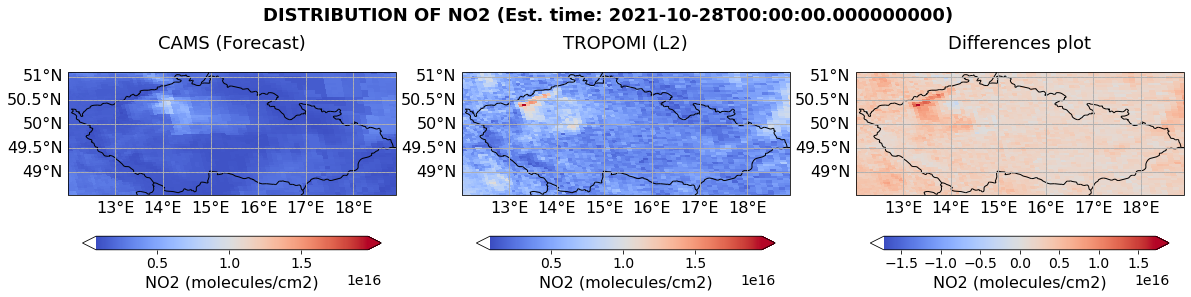

In [20]:
# Choose distribution (aggregated, individual or animated)
distribution_type = 'individual'

# Choose range (original, equal or manual)
range_type = 'equal'
vmin_manual = None
vmax_manual = None

# Define projection and colors
projection = ccrs.PlateCarree()
color_scale = 'coolwarm' 
units = 'molecules/cm2'
visualize_model_vs_sensor(model, sensor, component_nom, units, merge_table, plot_dates, plot_bbox, 20, 0.80, 
                          model_type, sensor_type, range_type, distribution_type, projection,
                          color_scale, vmin_manual, vmax_manual)

### Compare CAMS original and averaged total columns

/home/alba/adc-toolbox/env-new/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1702: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


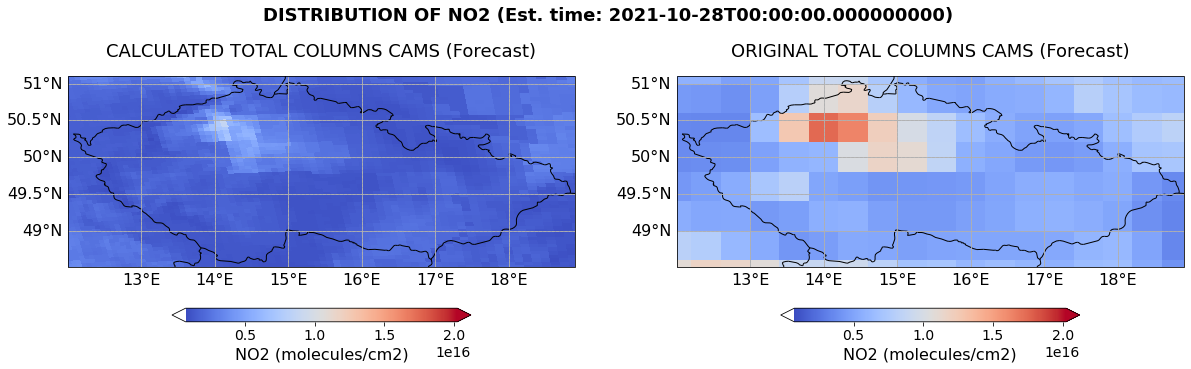

In [21]:
# Choose range (original, equal or manual)
range_type = 'equal' # original or equal
vmin_manual = None
vmax_manual = None

# Define projection and colors
projection = ccrs.PlateCarree()
color_scale = 'coolwarm' 

visualize_model_original_vs_calculated(model, component_nom,units, merge_table, model_total_ds, plot_dates, 
                                       plot_bbox, 20, 1, model_type, range_type, projection, color_scale,
                                       vmin_manual, vmax_manual)

## 7. Retrieve nearest values to specific latitude and longitude

In [22]:
coords_search_list = (50, 60,
                      4, 10,
                      20, 30)
retrieval_table_all =  retrieve_coords(merge_table.dropna(), coords_search_list, component_nom, 
                                       sensor, model, plot_dates, units)
retrieval_table_all

,,,,,scanline,ground_pixel,model_column,sensor_column,difference
lat_search,lon_search,latitude,longitude,time,,,,,
50,60,48.503414,19.290350,2021-10-28,171.0,408.0,1.071163e+15,3.227461e+15,2.156298e+15
4,10,48.279644,12.114426,2021-10-28,171.0,327.0,2.421664e+15,5.329478e+15,2.907814e+15
20,30,48.503414,19.290350,2021-10-28,171.0,408.0,1.071163e+15,3.227461e+15,2.156298e+15


## 8. Scatter plots by bbox

Fit equation: NO2_model = NO2_sensor * 0.24 + (7.68E+14)
Coefficient of determination (R2): 0.25


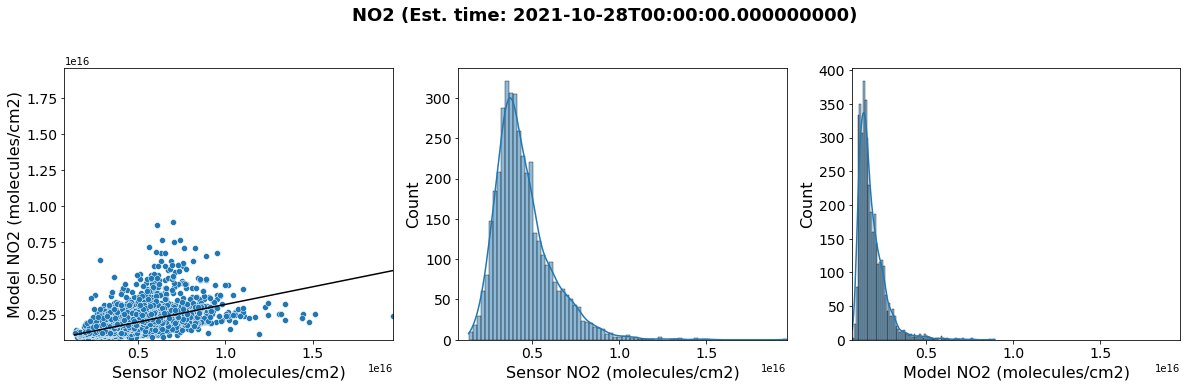

In [23]:
show_seasons = False
extent_definition = 'bbox' # bbox or country
scatter_plot_type = 'individual' # aggregated or individual

lim_min = None
lim_max = None

summary = scatter_plot(merge_table.dropna(), component_nom, units, sensor, plot_dates, 1.05, 
                       extent_definition, show_seasons, scatter_plot_type, lim_min, lim_max, plot_bbox)

In [24]:
summary

,Period,Location,Score,Coefficient,Intercept
0,2021-10-28,"((12, 48.5), (18.9, 51.1))",0.247635,0.243836,7.679777e+14


## 9. Scatter plots by season

Fit equation: NO2_model = NO2_sensor * 0.24 + (7.76E+14)
Coefficient of determination (R2): 0.24


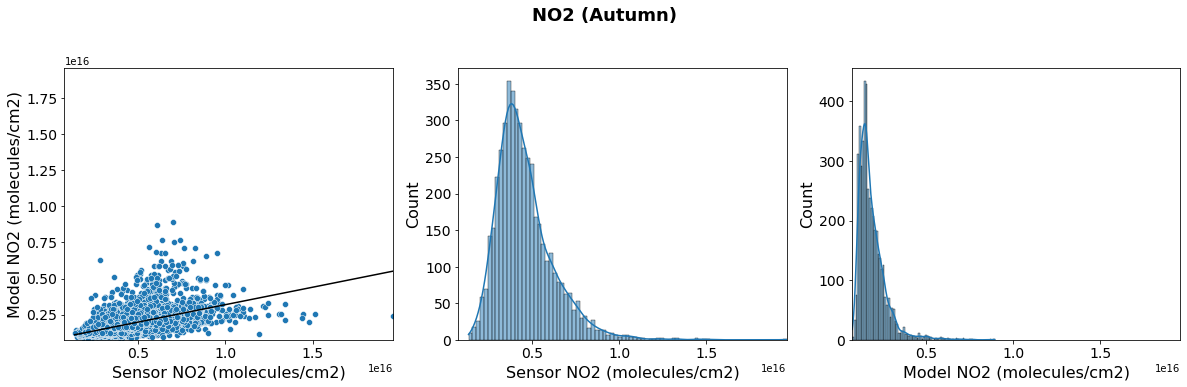

In [25]:
show_seasons = True
extent_definition = 'bbox' # bbox or country
scatter_plot_type = 'individual' # aggregated or individual

lim_min = None
lim_max = None

summary = scatter_plot(merge_table.dropna(), component_nom, units, sensor, plot_dates, 1.05, 
                       extent_definition, show_seasons, scatter_plot_type, lim_min, lim_max, plot_bbox)

In [26]:
summary

,Period,Location,Score,Coefficient,Intercept
0,Autumn,"((12, 48.5), (18.9, 51.1))",0.244908,0.24136,7.758196e+14


## 10. Scatter plots by country (Google API required!)

In [27]:
"""
show_seasons = False
extent_definition = 'country' # bbox or country
scatter_plot_type = 'aggregated' # aggregated or individual
plot_countries = ['Czech Republic', 'Poland', 'Germany']

lim_min = None
lim_max = None

scatter_plot(merge_table.dropna(), component_nom, units, sensor, plot_dates, 1.05, 
             extent_definition, show_seasons, scatter_plot_type, lim_min, lim_max, plot_countries)
"""

"\nshow_seasons = False\nextent_definition = 'country' # bbox or country\nscatter_plot_type = 'aggregated' # aggregated or individual\nplot_countries = ['Czech Republic', 'Poland', 'Germany']\n\nlim_min = None\nlim_max = None\n\nscatter_plot(merge_table.dropna(), component_nom, units, sensor, plot_dates, 1.05, \n             extent_definition, show_seasons, scatter_plot_type, lim_min, lim_max, plot_countries)\n"

In [28]:
#summary